In [0]:
!pip install transformers

In [115]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import torch
from torchtext  import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import BertTokenizer, BertModel, GPT2Model, GPT2Tokenizer

import nltk
from nltk import tokenize
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# TODO 

# Data

In [0]:
def open_file(file):
    with open(file, 'r', encoding='utf-8') as f:
        text_list = [line for line in f.readlines()]
    return text_list

In [8]:
# uncomment if google colab:
import os 
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')

fake = open_file("data/fake.txt")
real = open_file("data/real.txt")
df = pd.read_csv("data/dataset.csv")

print(len(fake), len(real), df.shape)
print(fake[:2])
print(real[:2])
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
37366 37366 (74732, 2)
['Spinach has terrorized generations of veggie-phobic kids, and many grownups don\'t much like it, either.."I think it\'s a little bit of a shock to see that he\'s been able to do this,"\n', 'All day, every day, Cheryl Bernstein thanks her 16-month-old son. the boy is a little boy.\n']
["Spinach has terrorized generations of veggie-phobic kids, and many grownups don't much like it, either. But when it's combined with seasonings and feta 

,text,label
0,"Is a skull from Petralona Cave, Greece, the ol...",real
1,The Network Readiness Index published by the W...,fake
2,Now they've got Justin Bieber too. He was just...,real
3,"NOGALES, Arizona — Jessica Elizabeth Orellana ...",real
4,Many companies that are using cloud computing ...,fake


In [0]:
# Convert dataset into DF with 'Text_Part1' 'Text_Part2' 'Label'
def sent_first(text):
    return tokenize.sent_tokenize(text)

def split_texts(texts):
    """
    Формирует новый датафрейм для проверки на домены.
    texts:: list of str (реальные тексты)
    """
    
    domains_df = pd.DataFrame()
    text_first = []
    text_second = []
    labels = []

    for ind, text in enumerate(texts):        
        real_first = tokenize.sent_tokenize(text)[0]
        try:
            real_second = tokenize.sent_tokenize(text)[1]
            fake_second = fake[ind].split(real_first)[1]
        except:
            continue
        
        text_first.append(real_first)
        text_second.append(real_second)
        labels.append('real')

        fake_first = real_first
        fake_second = fake[ind].split(real_first)[1]
        text_first.append(fake_first)
        text_second.append(fake_second)
        labels.append('fake')        
        
    assert len(text_first) == len(text_second) == len(labels)  

    domains_df['first'] = text_first
    domains_df['second'] = text_second
    domains_df['label'] = labels 
    domains_df = domains_df.sample(frac=1).reset_index(drop=True)
    return domains_df

In [23]:
domains = split_texts(real)
domains.head()

,first,second,label
0,"Kenneth Davis: Oddly, what prepared me the mos...",. I was a scientist at the University of Calif...,fake
1,"So far, 2016 has been terrible for investors.",Global stocks have closed down every day of th...,real
2,Revealed: Michael Jackson had a secret son!,.The New York Times reported that Jackson had ...,fake
3,The mechanics of a rollover In the event you f...,1.\n,fake
4,The Mail Room Fund launched three years ago to...,The first was a $1 million donation from the H...,fake


In [0]:
df.to_csv('data/domains.csv', index=False)

# GPT Tokenizer and Embeddings

In [89]:
pretrained_weights = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_weights)
model = GPT2Model.from_pretrained(pretrained_weights)

embeddings_pretrained = model.get_input_embeddings()
embeddings_pretrained

Embedding(50257, 768)

In [0]:
def tokenize(text, tokenizer=tokenizer):
    return tokenizer.encode(text)

In [91]:
MAX_VOCAB_SIZE = 50000

classes={'fake': 1, 'real': 0}


TEXT = data.Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenize, 
             pad_first=True, lower=False) 
LABEL = data.LabelField(dtype=torch.float, use_vocab=True, preprocessing=lambda x: classes[x])


dataset = data.TabularDataset('data/domains.csv', 
                                format='csv', fields=[('first', TEXT), ('second', TEXT), ('label',LABEL),], 
                                skip_header=True)

TEXT.build_vocab(dataset,  max_size=MAX_VOCAB_SIZE, min_freq=2)
LABEL.build_vocab(dataset)
vocab = TEXT.vocab
print('Vocab size:', len(TEXT.vocab.itos))

train, test = dataset.split(0.8, stratified=True)
train, valid = train.split(0.8, stratified=True)

Vocab size: 38990


In [0]:
EMBEDDINGS_DIM = embeddings_pretrained.embedding_dim
VOCAB_SIZE = embeddings_pretrained.num_embeddings
EMB_PRETRAINED = True

# Model

In [48]:
a = torch.ones(2,3,10)
b = torch.ones(2,2,10)
print(a.size(), b.size())
print(a)


s = torch.sum(a, dim=1)/a.size()[1]
d = torch.sum(b, dim=1)/b.size()[1]
print(s.size(), d.size())

diff = s-d
print(diff.size())

torch.Size([2, 3, 10]) torch.Size([2, 2, 10])
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])
torch.Size([2, 10]) torch.Size([2, 10])
torch.Size([2, 10])


In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, 
                 emb_pretrained, embeddings):
        super(MyModel, self).__init__()
        self.emb_pretrained = emb_pretrained
        self.embedding =  embeddings if self.emb_pretrained else nn.Embedding(vocab_size, embed_size)    
        self.fc = nn.Linear(embed_size, 1)
    
    def forward(self, first, second):
        
        first = self.embedding(first)
        second = self.embedding(second)

        first = torch.sum(first, dim=1)/first.size()[1]
        second = torch.sum(second, dim=1)/second.size()[1]
        
        difference = first-second      
        x = self.fc(difference)
        return x

In [106]:
batch_size = 256
num_epochs = 10

model = MyModel(VOCAB_SIZE,
                embed_size=EMBEDDINGS_DIM,
                hidden_size=128,
                emb_pretrained = EMB_PRETRAINED,
                embeddings = embeddings_pretrained
               )
model.to(device)
# wandb.watch(model)
# wandb.init(project="dpl")

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    device=device,
    sort_key=lambda x: len(x.first),
    sort_within_batch=True,
)

#train_iterator = BucketIteratorWrapper(train_iterator)
#valid_iterator = BucketIteratorWrapper(valid_iterator)
#test_iterator = BucketIteratorWrapper(test_iterator)

optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, cooldown=5)
criterion = nn.BCEWithLogitsLoss()
criterion.to(device)

BCEWithLogitsLoss()

In [0]:
for i, batch  in enumerate(train_iterator):
    model.forward(batch.first, batch.second)
    break


In [0]:
def accuracy_score(preds, y):
    preds = torch.round(torch.sigmoid(preds))
    preds = (preds == y).float()
    accuracy = preds.sum() / len(preds)
    return accuracy.item()

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):
    model.train()

    running_loss = 0
    losses = []
    train_acc = []

    n_batches = len(iterator)
    
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)
    
    for i, batch in enumerate(iterator):
        first = batch.first
        second = batch.second
        y = batch.label
        optimizer.zero_grad()
        preds = model(first, second).squeeze(1)
        loss = criterion(preds, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        
        curr_loss = loss.data.detach().item()
        losses.append(loss.item())

        acc = accuracy_score(preds, y)
        train_acc.append(acc)

        iterator.set_postfix(loss='%.5f' % curr_loss, acc='%.5f' % acc)

#         wandb.log({
#         "Train Accuracy": np.mean(train_acc),
#         "Train Loss": curr_loss})

    return curr_loss, losses, train_acc

def _test_epoch(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    losses = []
    test_acc = []

    n_batches = len(iterator)

    with torch.no_grad():
        for batch in iterator:
            first = batch.first
            second = batch.second
            y = batch.label
            preds = model(first, second).squeeze(1)
            test_acc.append(accuracy_score(preds, y))

            loss = criterion(preds, y)
            losses.append(loss.item())
            epoch_loss += loss.data.item()

#     wandb.log({
#         "Valid Accuracy": np.mean(test_acc),
#         "Valid Loss": epoch_loss/n_batches})
    
    return epoch_loss / n_batches, losses, test_acc

def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=20, early_stopping=0):

    prev_loss = 10500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(n_epochs):
        train_loss, epoch_tl, train_acc = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss,  epoch_vl, valid_acc = _test_epoch(model, valid_iterator, criterion)

        train_losses.extend(epoch_tl)
        valid_losses.extend(epoch_vl)
        train_accs.extend(train_acc)
        valid_accs.extend(valid_acc)

        print('validation loss %.5f' % valid_loss, 'validation accuracy  %.5f' % np.mean(valid_accs))

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss, 'train_acc': np.mean(train_accs), 'valid_acc':np.mean(valid_accs)}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history

In [110]:
history = nn_train(model, train_iterator, valid_iterator,
          criterion, optimizer, n_epochs=100, early_stopping=2)

validation loss 0.70737 validation accuracy  0.57378


validation loss 0.69643 validation accuracy  0.58468


validation loss 0.67598 validation accuracy  0.59253


validation loss 0.66014 validation accuracy  0.59936


validation loss 0.65622 validation accuracy  0.60435


validation loss 0.64590 validation accuracy  0.60773


validation loss 0.64318 validation accuracy  0.61081


validation loss 0.64149 validation accuracy  0.61310


validation loss 0.64616 validation accuracy  0.61531


validation loss 0.64145 validation accuracy  0.61714


validation loss 0.64296 validation accuracy  0.61873


validation loss 0.64474 validation accuracy  0.61994
Early stopping! best epoch: 9 val 0.64145


In [0]:
def test_model(model, test_iterator):
    test_acc = []

    with torch.no_grad():
        for item in test_iterator:
            #x = item['features']
            #y = item['targets']
            first = item.first
            second = item.second
            y = item.label
            preds = model(first, second).squeeze(1)
            test_acc.append(accuracy_score(preds, y))
    #print(type(test_acc), type(test_acc[0]))
    test_acc = np.mean(test_acc) 
    return np.mean(test_acc)

In [112]:
test_accuracy = test_model(model, test_iterator)
print('Test accuracy: {}'.format(np.mean(test_accuracy)))

Test accuracy: 0.6274566514450207


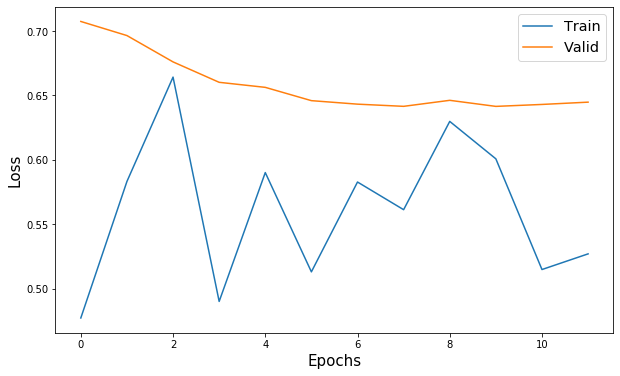

In [116]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['valid_loss'])), history['valid_loss'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

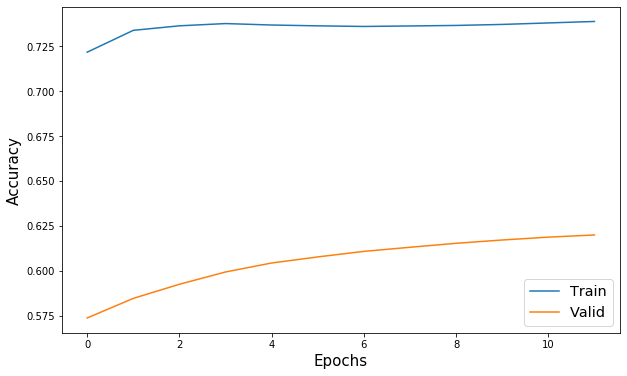

In [117]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_acc'])), history['train_acc'], label='Train')
plt.plot(np.arange(len(history['valid_acc'])), history['valid_acc'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()